In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import clear_output
import keras
import numpy as np
import pandas as pd
import h5py

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, GRU

Using TensorFlow backend.


# Configuramos las variables

In [2]:
x_features = 4
batch_size = 2000
epochs = 6000
train_perc=0.65
dev_perc = 0.25
test_perc = 0.10

# Cargamos los datos iniciales

In [3]:
data =pd.read_csv('Untitled.csv', usecols=['Payloads'])
#with open('attacks.txt') as f:
    #content = f.readlines()
# you may also want to remove whitespace characters like `\n` at the end of each line
payloads = data['Payloads'].apply(lambda x: x[1:-1]).tolist()
#[payloads.append(x.strip()[:-3]) for x in content]
with open('sqlattacks.txt') as f:
    content = f.readlines()
[payloads.append(x.strip()) for x in content]
payloads = pd.Series(payloads)
payloads = payloads.sample(frac=1).reset_index(drop=True)
payloads.size

11600

In [4]:
import string
vocabulary = string.printable
def row_parse(row):
  def char_parse(char):
    return vocabulary.index(char)
  return [char_parse(char) for char in row]

ascii_rows= [row_parse(row) for row in payloads]
print("Vocabulary length: ", len(vocabulary))
print("Dataset length: ", len(ascii_rows))

Vocabulary length:  100
Dataset length:  11600


In [5]:
def reduce_dimension(row, x_features):
  def create_new_row(index,char):
    past_pos = x_features-1
    new_row = [None for i in range(x_features+1)]
    def fill_past():
        if index > past_pos:
            for i in range(past_pos*-1, 0, 1):
                pos = index-i
                if(pos >= 0):
                    new_row[past_pos + i]= row[index+i]
        else:
            for i in range(x_features, 0 , -1):
                if(index- i) >= 0:
                    x =(index -i)+1
                    new_row[past_pos-x] = row[index-x]
    def fill_future():
        if (index+1) < len(row):
            new_row[-1] = row[index+1]
                
    fill_past()
    new_row[past_pos] = char
    fill_future()
    return new_row
  return [create_new_row(index,char) for index, char in enumerate(row)]
#char_relationships


In [6]:
def split_row(x, y, row):
  def split_tuple(tuple):
    x_zeros = np.zeros((x_features, 101))
    y_zeros = np.zeros((101))
    def getIndex(index):
      return 100 if index == None else index
    for i in range(x_features):
        x_zeros[i][getIndex(tuple[i])] = 1
    x.append(x_zeros)
    y_zeros[getIndex(tuple[-1])] = 1
    y.append(y_zeros)
  [split_tuple(tuple) for tuple in row]
print("Hecho")

Hecho


In [7]:
def split_train_sets(x_features):
    x = [];
    y = [];
    [split_row(x, y, char_relationship) for char_relationship in [reduce_dimension(row, x_features) for row in ascii_rows]]
    print(len(x))
    train_rows = int(len(x) * train_perc)
    print(train_rows)

    dev_rows = int(len(x) * dev_perc)
    print(dev_rows)

    test_rows = int(len(x) * test_perc)
    print(test_rows)
    x_train = np.array(x[train_rows-1:])
    y_train = np.array(y[train_rows-1:])
    x_dev = np.array(x[train_rows: (train_rows + dev_rows -1)])
    y_dev = np.array(y[train_rows: (train_rows + dev_rows -1)])
    x_test = np.array(x[:dev_rows])
    y_test = np.array(y[:dev_rows])
    return [x_train, y_train, x_dev, y_dev, x_test, y_test]

In [8]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        plt.savefig('{}.png'.format(file_name))
        plt.show();
plot = PlotLearning()

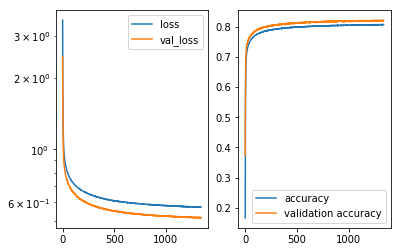

Epoch 1342/6000


In [ ]:
#bottle_neck = 10
#model.train_on_batch(x, y) and model.test_on_batch(x, y)
for x_features in [4]:
    print("=============== FEATURE =============")
    print(x_features)
    [x_train, y_train, x_dev, y_dev, x_test, y_test] = split_train_sets(x_features)
    for bottle_neck in [20]:
        file_name = 'model_feat-{}_botneck-{}'.format(x_features,bottle_neck)
        model = Sequential()
        model.add(GRU(101, input_shape=(x_features, 101), return_sequences=False))
        model.add(Dense(bottle_neck))
        model.add(Dropout(0.2, input_shape=(bottle_neck,)))
        model.add(Dense(101, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.summary()
        history=model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2,callbacks=[plot], validation_data=(x_dev, y_dev))
        print(history)
        model.save('{}.h5'.format(file_name))
        plt.savefig('{}.png'.format(file_name))

Salvamos el modelo

In [ ]:
def to_ascii(row):
    for i,elem in enumerate(row):
        if elem == 1:
            return vocabulary[i]

In [ ]:
def transform_predict(y_predict):
    index = np.argmax(y_predict)
    if index == 100:
        return None
    return vocabulary[index]
predict_chars=[transform_predict(y_predict) for y_predict in model.predict(x_train)]
predict_texts = [[]]
def build_text(predict_char):
    if predict_char == None:
        predict_texts.append([]);
    else:
        predict_texts[-1].append(predict_char)
[build_text(predict_char) for predict_char in predict_chars]
[''.join(predict_text) for predict_text in predict_texts]

In [ ]:
predict_chars=[transform_predict(y_predict) for y_predict in model.predict(x_test)]
predict_texts = [[]]
[build_text(predict_char) for predict_char in predict_chars]
[''.join(predict_text) for predict_text in predict_texts]

# Ahora tenemos que hacer una función de evaluación que coja la media del coste

Primero tenemos que descomponer un texto

In [ ]:
#demo_text= "' OR '1'='"
#demo_text="'"
#demo_text = "Esto seguro que no es ataque"
#demo_text = "AND 1=utl_inaddreget_host_address((SELECT DISTINCT(gSER)AME) FROM (SELECT DISTINCT(gSER)AME)  ROWNUM AS LIMIT=FRO"
demo_text = '") AND ELT(4841=4841,6023) AND ("BfsJ" LIKE "BfsJ"'
#demo_text = "SELECT DISTINCT"
#demo_text = "DISTINCT SELECT"
# Descomponemos el texto
elems = [reduce_dimension(row_parse(demo_text))]
x_demo = []
y_demo = []
[split_row(x_demo, y_demo, elem) for elem in elems]

In [ ]:
predict_chars=[transform_predict(y_predict) for y_predict in model.predict(np.array(x_demo))]
print(predict_chars)
predict_texts = [[]]
[build_text(predict_char) for predict_char in predict_chars]
[''.join(predict_text) for predict_text in predict_texts]

In [ ]:
olor=[[demo_text[i], model.evaluate(np.expand_dims(x_demo[i], axis=0), np.expand_dims(y_demo[i], axis=0),batch_size=batch_size, verbose=2)] for i in range(len(demo_text))]
[elem for elem in olor]

In [ ]:
[model.evaluate(np.expand_dims(x_demo[0], axis=0), np.expand_dims(y_demo[0], axis=0))
demo_text


In [ ]:
[[model.evaluate(np.expand_dims(x_demo[i], axis=0), np.expand_dims(y_demo[i], axis=0),
                                              batch_size=batch_size, verbose=2)] for i in range(len(x_demo))]

In [ ]:
print("Cuanto huele en %")
cuanto = 0
for elem in olor:
    cuanto+= elem[1][1]
print(cuanto/len(olor))